In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import transbigdata as tbd
import warnings
warnings.filterwarnings('ignore')

In [2]:
filepath = '小拓扑网络2/'

In [3]:


data = gpd.read_file('高速公路/gis/简化高速/广东省高速公路网_补充后_简化.json')
#提取简化高速公路边信息
edge = data[['geometry']]
edge ['edge_id'] = range (len (edge))
#生成反向边信息
edge_inverse = edge.copy ()
from shapely.geometry import LineString
edge_inverse['geometry'] = edge_inverse['geometry'].apply(lambda x:LineString(list(x.coords)[::-1]))
edge_inverse['edge_id'] +=len (edge)
#合并正反向边信息
edge = pd. concat([edge, edge_inverse])
edge

,geometry,edge_id
0,"LINESTRING (110.14661 20.26271, 110.14665 20.2...",0
1,"LINESTRING (110.13244 20.33307, 110.13250 20.3...",1
2,"LINESTRING (110.13250 20.33423, 110.13328 20.3...",2
3,"LINESTRING (110.13431 20.33518, 110.13328 20.3...",3
4,"LINESTRING (110.13431 20.33518, 110.13541 20.3...",4
...,...,...
24370,"LINESTRING (112.97290 25.29675, 112.97222 25.2...",48745
24371,"LINESTRING (112.97290 25.29675, 112.97197 25.2...",48746
24372,"LINESTRING (112.97222 25.29837, 112.97127 25.2...",48747
24373,"LINESTRING (112.97127 25.29949, 112.97096 25.3...",48748


In [4]:
gdtollnode = pd.read_csv('高速公路/gis/收费站服务区/收费站_all_wgs84.csv')
gdtollnode['name'] = gdtollnode['name'].apply(lambda r:r.split('(')[0])
gdtollnode.drop_duplicates('name',inplace=True)
gdtollnode = gpd.GeoDataFrame(gdtollnode, geometry=gpd.points_from_xy(gdtollnode['lon'], gdtollnode['lat']))
len(gdtollnode)

highway_station = pd.read_csv('高速公路/gis/收费站服务区/服务区_all_wgs84.csv')
highway_station['operId'] = range(len(highway_station))
highway_station = gpd.GeoDataFrame(highway_station, geometry=gpd.points_from_xy(highway_station['lon'], highway_station['lat']))
highway_station = highway_station[['lon','lat','geometry','operId']]
highway_station.columns = ['stationLon','stationLat','geometry','operId']
highway_station['freeNums'] = 10

#highway_station = gpd.read_file('高速公路/充电站.json')
#highway_station = highway_station[['stationLon','stationLat','freeNums','geometry','operId']]
highway_station = gpd.GeoDataFrame(highway_station)
''' highway_station = tbd.ckdnearest_line(highway_station,data)
highway_station = highway_station[highway_station['dist']<1000/111000] '''
highway_station = highway_station[['stationLon','stationLat','operId','freeNums']]
highway_station =  gpd.GeoDataFrame(highway_station)
highway_station['geometry']  = gpd.points_from_xy(highway_station['stationLon'],highway_station['stationLat'])
highway_station.columns = ['lon','lat','场站名称','充电车位数','geometry']
highway_station['充电车位数'] = np.maximum(highway_station['充电车位数'],4)
highway_station[['lon','lat','场站名称','充电车位数']]#.to_csv(r'newdata/chargestation_guangdong.csv',index = None)

#gdtollnode = pd.read_csv('高速公路/广东省高速公路网_收费站.csv')
gdtollnode['id'] = range(len(gdtollnode))
gdtollnode.to_file(r'高速公路/gis/收费站服务区/收费站_all_wgs84_去重.geojson', driver='GeoJSON')
gdtollnode = gdtollnode[['lon','lat','id']]

#highway_station = pd.read_csv('高速公路/广东省高速公路网_服务区.csv')
highway_station['id'] = range(len(highway_station))
highway_station['id'] += len(gdtollnode)

station = pd.concat([gdtollnode, highway_station])
station = gpd. GeoDataFrame (station).reset_index(drop=True)
station ['geometry'] = gpd.points_from_xy(station['lon'],station['lat'])


In [5]:




def get_matched_edge(edge,station):

    # 投影、偏移、匹配至最近的边
    dist = 50
    # 偏移100米的边
    edge_offset = edge.copy()
    edge_offset.crs = 'EPSG:4326'
    edge_offset_proj = edge_offset.to_crs('EPSG:4525') #CGCS2000 / 3-degree Gauss Kruger zone 37
    edge_offset_proj['geometry'] = edge_offset_proj['geometry'].apply(lambda x:x.parallel_offset(dist))
    edge_offset_proj = edge_offset_proj.reset_index(drop=True)
    edge_offset_proj = edge_offset_proj[-edge_offset_proj['geometry'].is_empty]

    station.crs = 'EPSG:4326'
    station_proj = station.to_crs('EPSG:4525')
    station_proj_match = tbd.ckdnearest_line(station_proj,edge_offset_proj[-edge_offset_proj['geometry'].is_empty][['edge_id','geometry']])

    # 对于只匹配到一个点的边
    matched_table_1 = station_proj_match.drop_duplicates(subset=['edge_id'],keep='first')[['edge_id','id']]
    matched_table_2 = station_proj_match[-station_proj_match['id'].isin(matched_table_1['id'])]

    # 基于额外节点调整网络
    for i in range(len(matched_table_1)):
        r = matched_table_1.iloc[i]
        nodeid = r['id']
        edgeid = r['edge_id']
        nodegeometry = station[station['id']==nodeid]['geometry'].iloc[0]
        edgegeometry = edge[edge['edge_id']==edgeid]['geometry'].iloc[0]
        #找到edge上距离node最近的点
        projectdist = edgegeometry.project(nodegeometry)
        projectpoint = edgegeometry.interpolate(projectdist)
        #如果在两端，则不需要切分
        #增加端点到节点的线段
        add_edges = []
        if (projectdist==edgegeometry.length)|(projectdist==0):
            line3 = LineString([nodegeometry,projectpoint])
            line4 = LineString([projectpoint,nodegeometry])
            add_edges.append(line3)
            add_edges.append(line4)
        else: #如果在中间，则需要切分，将原始边切分为两段，再加上端点到节点的线段
            from shapely.geometry import Point
            edge_coords = pd.DataFrame(edgegeometry.coords)
            edge_coords['proj'] = edge_coords.apply(lambda r:edgegeometry.project(Point([r[0],r[1]])),axis = 1)
            # 由中间端点切分边为两段
            line1 = LineString(edge_coords[edge_coords['proj']<projectdist][[0,1]].apply(lambda r:Point([r[0],r[1]]),axis = 1).tolist()+[projectpoint])
            line2 = LineString([projectpoint] + edge_coords[edge_coords['proj']>projectdist][[0,1]].apply(lambda r:Point([r[0],r[1]]),axis = 1).tolist())
            # 添加中间端点到收费站的线段
            line3 = LineString([nodegeometry,projectpoint])
            line4 = LineString([projectpoint,nodegeometry])
            add_edges.append(line1)
            add_edges.append(line2)
            add_edges.append(line3)
            add_edges.append(line4)
            # 此时需要删除原有的边
            edge = edge[edge['edge_id']!=edgeid]
        # 将新的边加入
        add_edges = gpd.GeoDataFrame(geometry=add_edges)
        edge = pd.concat([edge,add_edges])
    edge = edge[edge.length>0]
    edge['edge_id'] = range(len(edge))
    return edge,matched_table_2

edge,matched_table_2 = get_matched_edge(edge,station)
while len(matched_table_2)>0:
    edge,matched_table_2 = get_matched_edge(edge,station[station['id'].isin(matched_table_2['id'])])

# 构建节点表
edge['slon'] = edge['geometry'].apply(lambda r:r.coords[0][0])
edge['slat'] = edge['geometry'].apply(lambda r:r.coords[0][1])
edge['elon'] = edge['geometry'].apply(lambda r:r.coords[-1][0])
edge['elat'] = edge['geometry'].apply(lambda r:r.coords[-1][1])


In [6]:

# 提取简化高速公路节点信息
node = pd.concat([edge[['slon','slat']].rename(columns = {'slon':'lon','slat':'lat'}),
                  edge[['elon','elat']].rename(columns = {'elon':'lon','elat':'lat'})]).drop_duplicates()
node['geometry'] = gpd.points_from_xy(node['lon'],node['lat'])
node['id'] = range(len(node)) 

# 生成收费站节点对应网络节点的编号
station2node = tbd.ckdnearest_point(station,node)[['id_x','id_y']].rename(columns = {'id_x':'station_id','id_y':'node_id'})

# 为边添加起终点接节点信息
## 添加起点信息
node_tmp = node[['lon','lat','id']]
node_tmp.columns = ['slon','slat','u']
edge = pd.merge(edge,node_tmp,on = ['slon','slat'],how = 'left')
## 添加终点信息
node_tmp = node[['lon','lat','id']]
node_tmp.columns = ['elon','elat','v']
edge = pd.merge(edge,node_tmp,on = ['elon','elat'],how = 'left')

edge = gpd.GeoDataFrame(edge,geometry = 'geometry')

edge.crs = 'EPSG:4326'
edge['length'] = edge.to_crs('EPSG:4525').length
edge = edge[edge['length']>0]

In [7]:

# 高速公路边向右平移一定距离形成面
def generate_plane(edge,dist = 100):
    '''
    高速公路边向右平移一定距离形成面

    '''
    ## 转换为投影坐标系
    edge.crs = 'EPSG:4326'
    edge['length'] = edge.to_crs('EPSG:4525').length

    edge = edge[edge['length']>50]
    edge_plane = edge.to_crs('EPSG:4525') #CGCS2000 / 3-degree Gauss Kruger zone 37
    edge['length'] = edge_plane['geometry'].length

    ## 生成单方向偏移
    from shapely.geometry import Polygon
    edge_plane['geometry'] = edge_plane['geometry'].apply(lambda x:Polygon(list(x.coords)+list(x.parallel_offset(dist).coords)))
    edge_plane = edge_plane.to_crs('EPSG:4326')
    return edge_plane

edge_plane = generate_plane(edge,dist = 100)

In [8]:

#存储边、面与节点信息
edge.to_file(filepath+r'广东省高速公路_简化_边.json',driver = 'GeoJSON')
edge_plane.to_file(filepath+r'广东省高速公路_简化_面.json',driver = 'GeoJSON')
node = gpd.GeoDataFrame(node)
node.to_file(filepath+r'广东省高速公路_简化_节点.json',driver = 'GeoJSON')
station2node.to_csv(filepath+r'收费站节点对应网络节点的编号.csv',index = None)

<AxesSubplot:>

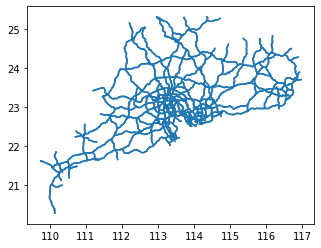

In [12]:
edge.plot()

In [9]:
len(station2node)

1450

In [10]:
#存储边、面与节点信息
edge = gpd.read_file(filepath+r'广东省高速公路_简化_边.json')
node = gpd.read_file(filepath+r'广东省高速公路_简化_节点.json')
station2node = pd.read_csv(filepath+r'收费站节点对应网络节点的编号.csv')
# 将station2node转换为字典
station2node_dict = station2node.set_index('station_id')['node_id'].to_dict()


In [13]:
G_edges = edge[['u','v','length']].values
G_nodes = list(node['id'])

import networkx as nx
#先创建一个有向图
G = nx.DiGraph()
#添加节点
G.add_nodes_from(G_nodes) 
#添加边
G.add_weighted_edges_from(G_edges)

## OD表构建
o = gdtollnode[['id']].copy()
o.columns = ['station_id']
#o = station2node[['station_id']]
o['flag'] = 1
d = o.copy()
od = pd.merge(o,d,on = 'flag')[['station_id_x','station_id_y']]
od = od[od['station_id_x']!=od['station_id_y']]

# 获取出行路径
def getshortestpath(r):
    # 获取出行路径
    start_node = station2node_dict[r['station_id_x']]
    end_node = station2node_dict[r['station_id_y']]
    shortest_path = nx.shortest_path(G, source=start_node, target=end_node)
    return list(map(int,shortest_path))# 转为整型

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

# 获取OD的出行路径
od['path'] = od.parallel_apply(lambda r:getshortestpath(r),axis = 1)
# 对OD编号
od['odid'] = range(len(od))
od.to_csv(filepath+r'OD路径表.csv',index = None)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [ ]:
od = pd.read_csv(filepath+r'OD路径表.csv')
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

def get_path_gdf_1(shortest_path):
    '''
    从点序列中获取出行路段
    '''
    path = pd.DataFrame(shortest_path,columns=['u'])
    path['u'] = path['u'].astype(int)
    path['v'] = path['u'].shift(-1).fillna(0).astype(int)
    path = path.iloc[:-1]
    path = gpd.GeoDataFrame(path)
    path['id'] = range(len(path))
    return path
#path = get_path_gdf(shortest_path,edge)
import ast
def get_path_dis_table_1(r):
    '''
    获取OD所经过的路段信息
    '''
    shortest_path = ast.literal_eval(r['path'])
    path = get_path_gdf_1(shortest_path)
    path = path[['u','v','id']]
    path['station_id_x'] = r['station_id_x']
    path['station_id_y'] = r['station_id_y']
    return path
od1_tmp = od.groupby('odid').parallel_apply(lambda r:get_path_dis_table_1(r.iloc[0])).reset_index()[['station_id_x','station_id_y','u','v','id']]
od1_tmp = pd.merge(od1_tmp,edge)[['station_id_x','station_id_y','edge_id','length','id']]

od1_tmp = od1_tmp.sort_values(by = ['station_id_x','station_id_y','id'])
od1_tmp['cumsumlength'] = od1_tmp.groupby(['station_id_x','station_id_y'])['length'].cumsum()
od_dis_table = od1_tmp[['station_id_x','station_id_y','edge_id','cumsumlength']]

# od_dis_table存储了每个OD对应的路段信息
# 其中，station_id_x、station_id_y为OD的起点、终点
# edge_id为经过路段的id，cumsumlength为经过路段的累计长度
# 例如，station_id_x=0，station_id_y=1，edge_id=47784，cumsumlength=68.596574，表示OD为0-1的出行路径，需要经过id为47784的路段，路径走完这一路段时，所经过的长度为68.596574米
od_dis_table.to_csv(filepath+r'od_dis_table.csv',index = None)


od_length = od_dis_table.groupby(['station_id_x','station_id_y'])['cumsumlength'].max().rename('length').reset_index()
od_length.to_csv(filepath+r'od_length.csv',index = None)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


NameError: name 'edge' is not defined

In [ ]:
highway_station = pd.merge(highway_station,station2node,left_on = 'id',right_on = 'station_id')

In [ ]:
# find the nearest charge node
def get_nearest_charge_station(G,node_id, radius = 1000):
    # create subgraph
    subgraph = nx.ego_graph (G, node_id, radius=radius,distance = 'weight')
    distances = []
    stationid = None
    stationdistance = None
    for node in subgraph.nodes() :
        if (node in list(highway_station ['node_id'])):# if it is charge station
            distance = nx.shortest_path_length(subgraph,source=node_id, target=node,weight='weight')
            distances.append ( [node, distance])
    distances = pd.DataFrame (distances, columns=['stationid', 'distance']) .sort_values (by='distance')
    # if there is a charge staion
    if len (distances)>0:
        stationid = int (distances ['stationid'].iloc [0])
        stationdistance = int (distances ['distance'].iloc[0])
    return stationid, stationdistance
stationid,stationdistance = get_nearest_charge_station(G,0, radius = 1000)
stationid,stationdistance

(None, None)

In [ ]:
# find the nearest charge node
G_nodes_df = pd. DataFrame (G_nodes,columns = ['node_id'])
a = G_nodes_df['node_id'].parallel_apply(lambda node_id:get_nearest_charge_station(G,node_id,radius = 1000))
G_nodes_df['charge_node_id'] = a.apply(lambda r:r [0])
G_nodes_df['charge_node_distance'] = a.apply (lambda r:r [1])

In [ ]:
edge_to_charge = pd.merge(edge[['edge_id', 'v']].rename(columns={'v': 'node_id'}),
                          G_nodes_df)[['edge_id', 'charge_node_id', 'charge_node_distance']]
edge_to_charge = pd.merge(edge_to_charge,
                          highway_station[['场站名称', '充电车位数', "node_id"]].rename(
                              columns={'node_id': 'charge_node_id'})).sort_values(by='edge_id')
edge_to_charge.to_csv(filepath+r'edge_to_charge.csv',index = None)


In [ ]:
import pandas as pd
od_dis_table = pd.read_csv(filepath+r'od_dis_table.csv')

# 合并列表
od_merge_table = od_dis_table.groupby(['station_id_x', 'station_id_y']).agg(
    {'edge_id': list, 'cumsumlength': list}).reset_index()
# od_merge_table.to_csv('input/od_merged_table.csv')
# cumsumlength处理
def calculate_differences(lst):
    differences = [lst[i] - lst[i - 1] for i in range(1, len(lst))]
    return [lst[0]] + differences
od_merge_table['cumsumlength2'] = od_merge_table['cumsumlength']

od_merge_table['cumsumlength'] = od_merge_table['cumsumlength'].apply(calculate_differences)
od_merge_table.to_csv('abm/input/new_od_dis.csv') 

OSError: Cannot save file into a non-existent directory: 'input'